<a href="https://colab.research.google.com/github/billycemerson/quantitative-finance-project/blob/main/02_traditional_ts/arima_family.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Library & Package

In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats & TS
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Auto ARIMA
from pmdarima import auto_arima

# Stats
from scipy.stats import jarque_bera

#### Get Data

In [4]:
ticker = "BBCA.JK"
start_date="2021-01-01"
end_date="2024-12-31"

In [5]:
data = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    progress=False
)

data = data[['Close']].dropna()
data.head()

/tmp/ipython-input-3957227690.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Price,Close
Ticker,BBCA.JK
Date,
2021-01-04,6028.375488
2021-01-05,6253.281250
2021-01-06,6125.393066
2021-01-07,6143.033203
2021-01-08,6218.001465


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 969 entries, 2021-01-04 to 2024-12-30
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BBCA.JK)  969 non-null    float64
dtypes: float64(1)
memory usage: 15.1 KB


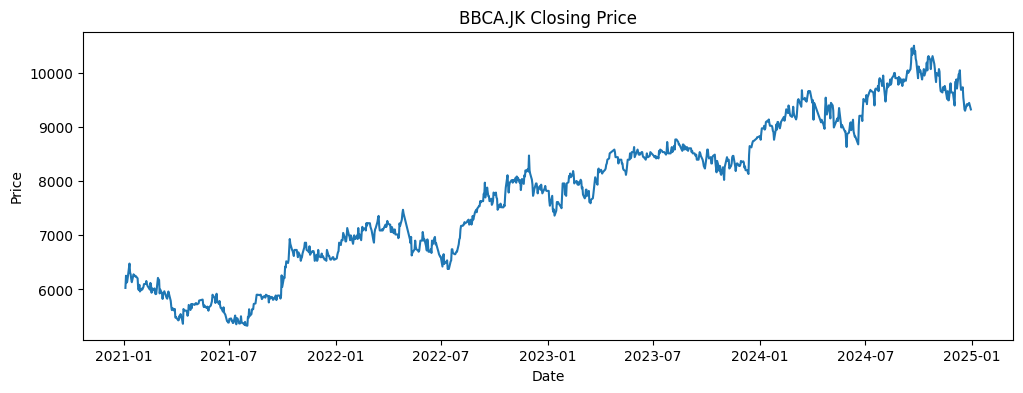

In [7]:
plt.figure(figsize=(12,4))
plt.plot(data.index, data['Close'])
plt.title(f"{ticker} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

#### Stationarity

In [8]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    return result[1] < 0.05

adf_test(data['Close'])

ADF Statistic: -0.9344
p-value: 0.7764


np.False_

The p-value from ADF test > 0.05, so the data is not stationner

To next analyze, we need to differencing the data

#### Apply Differencing

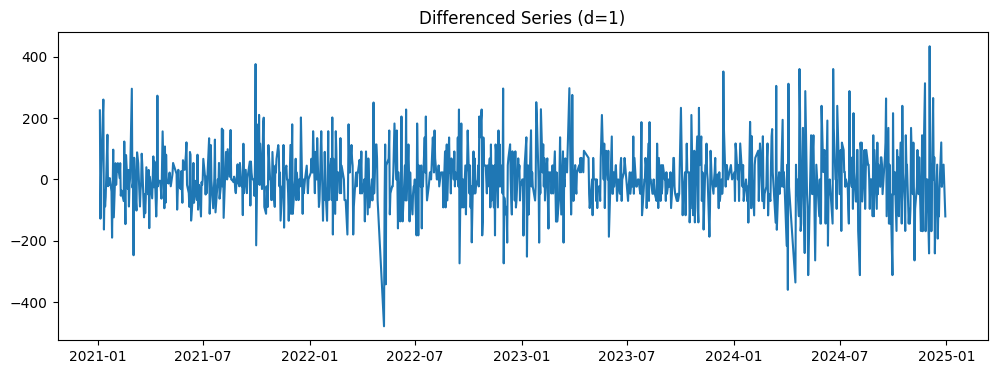

ADF Statistic: -25.5316
p-value: 0.0000


True

In [9]:
def difference_series(series, d=1):
    return series.diff(d).dropna()

d = 1
diff_series = difference_series(data['Close'], d)

plt.figure(figsize=(12,4))
plt.plot(diff_series)
plt.title(f"Differenced Series (d={d})")
plt.show()

adf_test(diff_series)

#### ACF & PACF

<Figure size 1200x400 with 0 Axes>

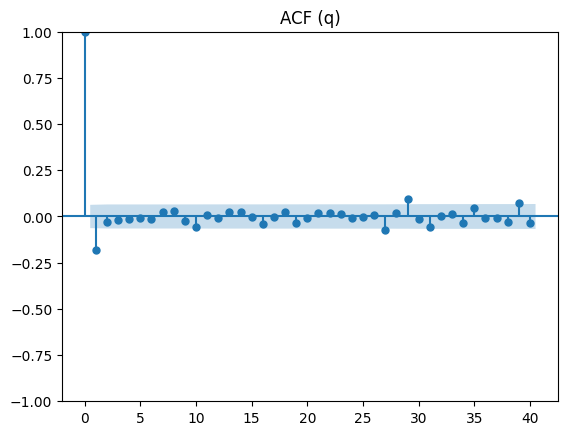

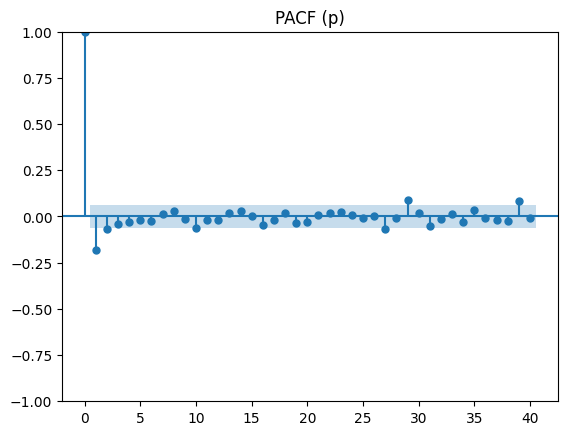

In [10]:
plt.figure(figsize=(12,4))
plot_acf(diff_series, lags=40)
plt.title("ACF (q)")
plt.show()

plot_pacf(diff_series, lags=40)
plt.title("PACF (p)")
plt.show()

In [11]:
p, q = 1, 1

#### ARIMA

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Auto ARIMA
auto_model = auto_arima(
    data['Close'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11727.466, Time=7.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11759.982, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11729.212, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11724.961, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11759.001, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11724.279, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11725.630, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11725.452, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11724.961, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11726.681, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11724.252, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11724.636, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11728.676, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=11725.783, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0

In [14]:
# Manual ARIMA
arima_model = ARIMA(data['Close'], order=(p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                BBCA.JK   No. Observations:                  969
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5859.126
Date:                Tue, 16 Dec 2025   AIC                          11724.252
Time:                        09:06:45   BIC                          11738.878
Sample:                             0   HQIC                         11729.820
                                - 969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2620      0.119      2.200      0.028       0.029       0.495
ma.L1         -0.4574      0.111     -4.109      0.000      -0.676      -0.239
sigma2      1.057e+04    362.413     29.179      0.0

#### SARIMA

In [15]:
seasonal_period = 21  # ~monthly trading days

sarima_model = ARIMA(
    data['Close'],
    order=(p, d, q),
    seasonal_order=(1, 0, 1, seasonal_period)
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          BBCA.JK   No. Observations:                  969
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 21)   Log Likelihood               -5857.668
Date:                          Tue, 16 Dec 2025   AIC                          11725.337
Time:                                  09:06:52   BIC                          11749.713
Sample:                                       0   HQIC                         11734.616
                                          - 969                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2599      0.119      2.192      0.028       0.027       0.492
ma.L1         -0.4579      0.111     -4.135      0.

#### ARIMAX

Add x variable (example: IHHSG)

In [16]:
ihsg = yf.download("^JKSE", start=start_date, end=end_date, progress=False)
ihsg['market_return'] = np.log(ihsg['Close']).diff()

df = pd.concat([
    data['Close'],
    ihsg['market_return']
], axis=1).dropna()

df.columns = ['price', 'market_return']
df.head()

,price,market_return
Date,,
2021-01-05,6253.281250,0.005300
2021-01-06,6125.393066,-0.011745
2021-01-07,6143.033203,0.014396
2021-01-08,6218.001465,0.016792
2021-01-11,6478.187988,0.019794


In [17]:
arimax_model = ARIMA(
    df['price'],
    order=(p, d, q),
    exog=df[['market_return']]
)

arimax_result = arimax_model.fit()
print(arimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  968
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5754.797
Date:                Tue, 16 Dec 2025   AIC                          11517.595
Time:                        09:06:55   BIC                          11537.092
Sample:                             0   HQIC                         11525.017
                                - 968                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
market_return  4132.8824    242.393     17.050      0.000    3657.801    4607.964
ar.L1             0.4602      0.164      2.799      0.005       0.138       0.782
ma.L1            -0.5712      0.154     

#### SARIMAX

In [18]:
sarimax_model = SARIMAX(
    df['price'],
    order=(p, d, q),
    seasonal_order=(1, 0, 1, seasonal_period),
    exog=df[['market_return']]
)

sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  968
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 21)   Log Likelihood               -5754.364
Date:                            Tue, 16 Dec 2025   AIC                          11520.728
Time:                                    09:07:08   BIC                          11549.973
Sample:                                         0   HQIC                         11531.861
                                            - 968                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
market_return  4132.8832    244.100     16.931      0.000    3654.455    4611.311
ar.L1             0.4457  

#### Conclusion

In [19]:
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "AIC": [
        arima_result.aic,
        sarima_result.aic,
        arimax_result.aic,
        sarimax_result.aic
    ],
    "BIC": [
        arima_result.bic,
        sarima_result.bic,
        arimax_result.bic,
        sarimax_result.bic
    ]
})

In [20]:
comparison_df.sort_values("AIC")

,Model,AIC,BIC
2,ARIMAX,11517.594768,11537.091562
3,SARIMAX,11520.727946,11549.973137
0,ARIMA,11724.252317,11738.878013
1,SARIMA,11725.336904,11749.713065


Based on AIC comparison across the ARIMA family models, the ARIMAX model achieves the lowest AIC value, indicating the best in-sample fit among the considered linear specifications.

#### Residual Diagnostics

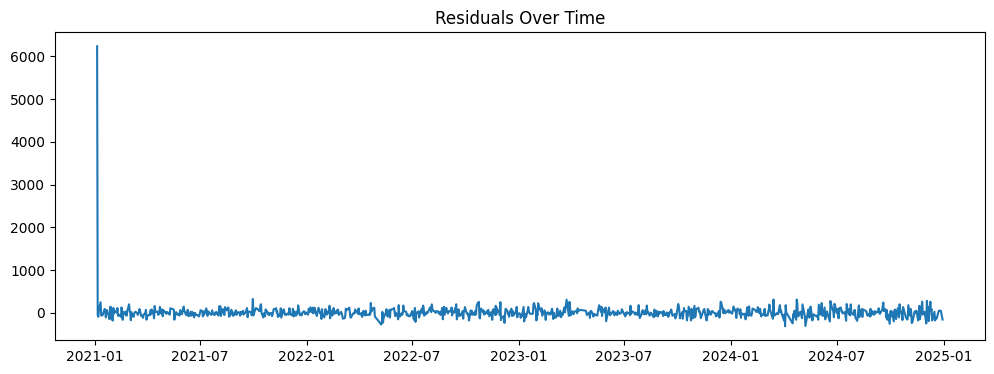

In [23]:
residuals = arimax_result.resid

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

<Figure size 1200x400 with 0 Axes>

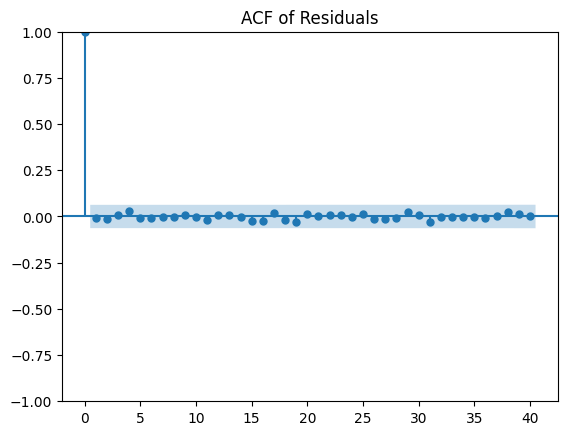

In [24]:
# ACF residuals
plt.figure(figsize=(12,4))
plot_acf(residuals.dropna(), lags=40)
plt.title("ACF of Residuals")
plt.show()

In [25]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,1.493508,0.998955
20,4.873639,0.999773


Residual diagnostics show no remaining linear autocorrelation, as confirmed by the Ljung–Box test, suggesting that the conditional mean dynamics are adequately captured.

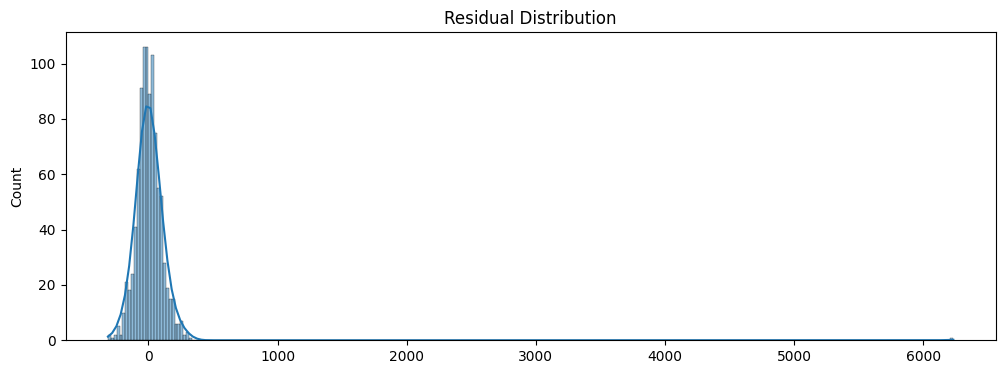

In [26]:
# Normality test
plt.figure(figsize=(12,4))
sns.histplot(residuals.dropna(), kde=True)
plt.title("Residual Distribution")
plt.show()

In [27]:
jb_stat, jb_p = jarque_bera(residuals.dropna())
jb_stat, jb_p

(np.float64(17187088.214222312), np.float64(0.0))

However, the Jarque–Bera test strongly rejects normality, revealing extreme fat-tailed behavior in the residuals. This indicates the presence of volatility clustering and tail risk that cannot be addressed by linear ARIMA-based models.

These findings motivate the use of volatility-focused and regime-switching models, such as GARCH and Hidden Markov Models, to better capture the risk structure of financial time series.

#### Try Forecasting

In [44]:
df.head()

,price,market_return
Date,,
2021-01-05,6253.281250,0.005300
2021-01-06,6125.393066,-0.011745
2021-01-07,6143.033203,0.014396
2021-01-08,6218.001465,0.016792
2021-01-11,6478.187988,0.019794


In [45]:
prices = df.copy()
# Ensure datetime index
prices = prices.tz_localize(None)
prices.index = pd.DatetimeIndex(prices.index).to_period(freq='B')
# Fill NaNs introduced by the PeriodIndex conversion
prices = prices.fillna(method='ffill')

# variable define
y = prices['price']
exog = prices['market_return']

In [46]:
split_idx = -30   # last 30 observations for test

train_data = y.iloc[:split_idx]
test_data  = y.iloc[split_idx:]

exog_train = exog.iloc[:split_idx]
exog_test  = exog.iloc[split_idx:]

In [55]:
# Example order from previous analysis
order = (1, 1, 1)

model = ARIMA(
    train_data,
    order=(p, d, q),
    exog=exog_train,
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_result = model.fit()
print(arimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  938
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5543.800
Date:                Tue, 16 Dec 2025   AIC                          11095.599
Time:                        09:21:03   BIC                          11114.962
Sample:                    01-05-2021   HQIC                         11102.982
                         - 11-13-2024                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
market_return  4119.1411    239.377     17.208      0.000    3649.971    4588.311
ar.L1             0.4876      0.175      2.785      0.005       0.144       0.831
ma.L1            -0.5875      0.165     

In [56]:
forecast_result = arimax_result.get_forecast(
    steps=len(test_data),
    exog=exog_test
)

forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

In [61]:
# FORCE forecast index to match test period
forecast.index = test_data.index
conf_int.index = test_data.index

In [64]:
def plot_forecast_full_history(train_data, test_data, forecast, conf_int, ticker):
    plt.figure(figsize=(12, 6))

    plt.plot(
        train_data.index.to_timestamp(),
        train_data.values,
        label='Training Data'
    )

    plt.plot(
        test_data.index.to_timestamp(),
        test_data.values,
        label='Actual',
        color='black'
    )

    plt.plot(
        forecast.index.to_timestamp(),
        forecast.values,
        label='Forecast',
        color='red'
    )

    plt.fill_between(
        forecast.index.to_timestamp(),
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        alpha=0.3,
        label='Confidence Interval'
    )

    plt.title(f'{ticker} - Forecast (Full History)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [65]:
def plot_forecast_zoomed(
    train_data,
    test_data,
    forecast,
    conf_int,
    ticker,
    zoom_window=50
):
    zoom_start = train_data.index[-zoom_window]

    plt.figure(figsize=(12, 6))

    plt.plot(
        train_data.loc[zoom_start:].index.to_timestamp(),
        train_data.loc[zoom_start:].values,
        label='Training Data'
    )

    plt.plot(
        test_data.index.to_timestamp(),
        test_data.values,
        label='Actual',
        color='black'
    )

    plt.plot(
        forecast.index.to_timestamp(),
        forecast.values,
        label='Forecast',
        color='red'
    )

    plt.fill_between(
        forecast.index.to_timestamp(),
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        alpha=0.3,
        label='Confidence Interval'
    )

    plt.xlim(
        zoom_start.to_timestamp(),
        test_data.index[-1].to_timestamp()
    )

    plt.title(f'{ticker} - Zoomed Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

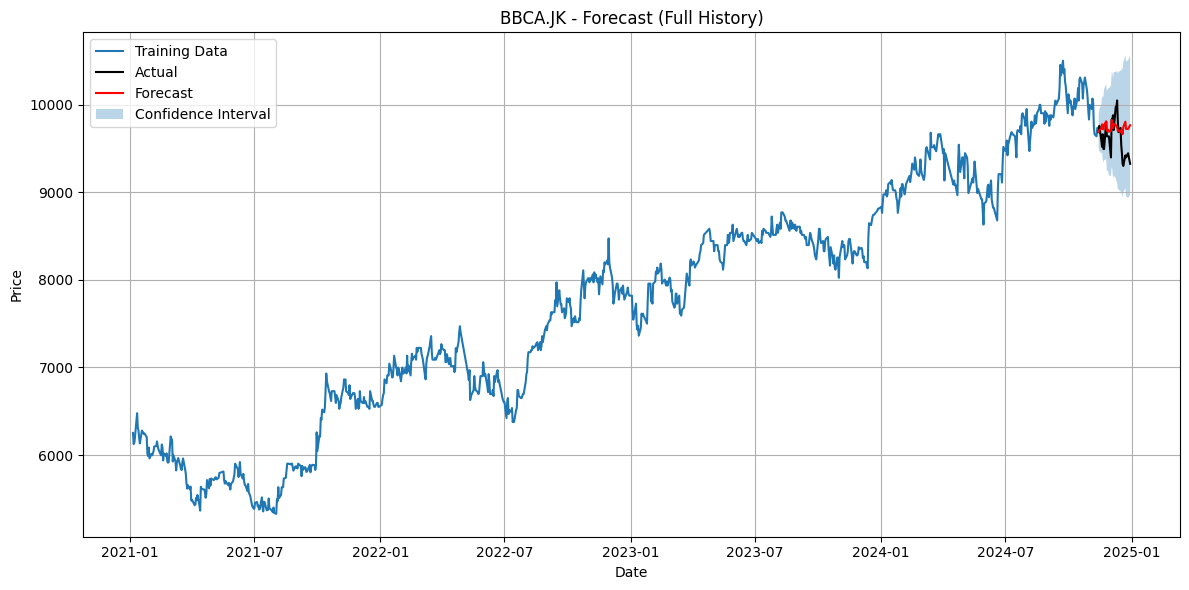

In [67]:
plot_forecast_full_history(
    train_data,
    test_data,
    forecast,
    conf_int,
    ticker
)

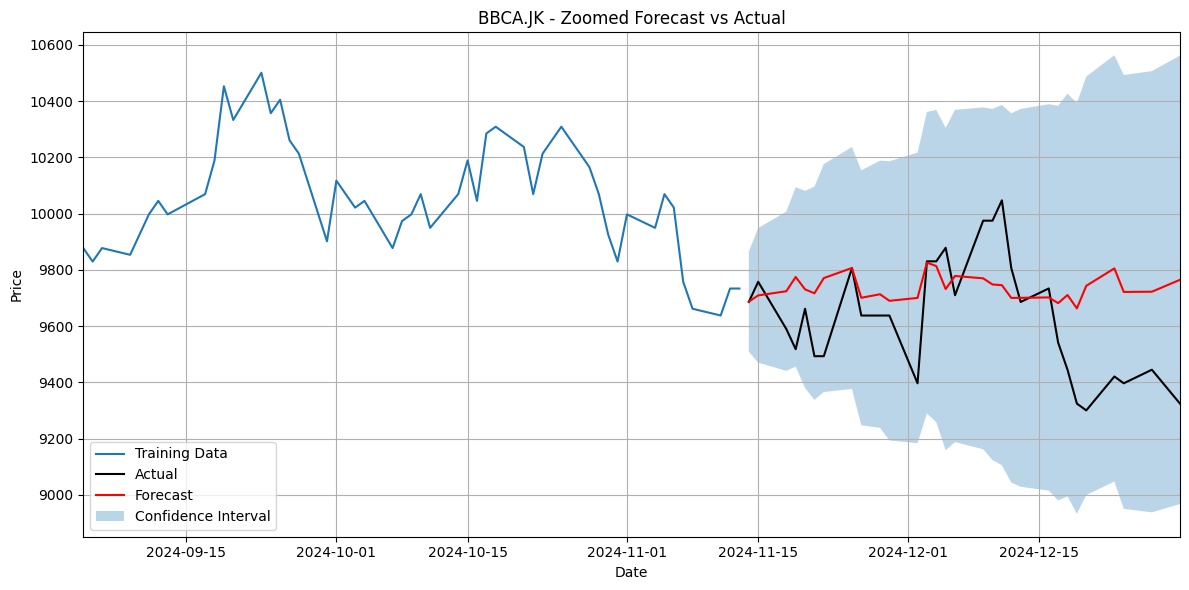

In [68]:
plot_forecast_zoomed(
    train_data,
    test_data,
    forecast,
    conf_int,
    ticker,
    zoom_window=50
)

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

In [70]:
y_true = test_data.values
y_pred = forecast.values

In [71]:
# Filter out NaNs from y_true and corresponding y_pred
valid_indices = ~np.isnan(y_true)
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

mse = mean_squared_error(y_true_filtered, y_pred_filtered)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

MSE: 49056.52
RMSE: 221.49
MAPE: 1.83%
